## Coordinate systems

## 
Our convention will be that the spherical coordinates are (r,$\phi$,$\theta$) for the (radial, azimuthal, and polar) coordinate, with $\theta$ measured from the pole. These coordinates are given in terms of the cartesian coordinates (x,y,z) as:

\begin{align}
    x  &= r\,\sin \theta\, \cos \phi\\
    y  &= r\,\sin \theta\, \sin \phi\\
    z  &= r\,\cos \theta
\end{align}

and

\begin{align}
    r       &= \sqrt{x^2 + y^2 + z^2}\\
    \phi    &= \mathrm{atan2}(y,x)\\
    \theta  &= \pi/2 - \mathrm{atan}(z/\sqrt{x^2+y^2})
\end{align}


where atan2 is the arctangent function with two arguments. We will typically define velocities in the spherical coordinate system to be ($v_{r}$,$v_{\phi}$,$v_{\theta}$) = ($\dot{r}$, r sin $\theta$ $\dot{\phi}$, r$\dot{\theta}$), where the dot denotes the time derivative. The relation between the velocity ($v_{x}$,$v_{y}$,$v_{z}$) in cartesian coordinates and that in spherical coordinates is then

\begin{align}
    v_x & = v_r\,\sin\theta\,\cos\phi-v_\phi\,\sin \phi+v_\theta\,\cos\theta\,\cos\phi\\
    v_y & = v_r\,\sin\theta\,\sin\phi+v_\phi\,\cos\phi+v_\theta\,\cos\theta\\
    v_z & = v_r\,\cos\theta\phantom{\,\sin\phi+v_\phi\,\cos\phi}-v_\theta\,\sin\theta
\end{align}


## Import packages

In [1]:
import astropy.coordinates as coord
from astropy.table import Table
import astropy.units as u
import numpy as np
from pylab import *

## Define position and velocity of the Sun

## 

U$_{\odot}$, V$_{\odot}$, and W$_{\odot}$ = $11.10 \pm 0.72$, $12.24 \pm 0.47$, and $07.25 \pm 0.36$ km/s adopted from [Schoenrich+2010](https://ui.adsabs.harvard.edu/abs/2010MNRAS.403.1829S/abstract)

R$\odot$ =  $8.178 \pm 0.013$\,kpc adopted from [Gravity Collaboration+2019](https://ui.adsabs.harvard.edu/abs/2019A%26A...625L..10G/abstract)

Z$\odot$ = $20.8 \pm 0.3$\,kpc adopted from [Bennett & Bovy2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.482.1417B/abstract)


circular velocity  = $220$\,km/s [Kerr & Lynden1986](https://ui.adsabs.harvard.edu/abs/1986MNRAS.221.1023K/abstract)




In [2]:
U_sun, V_sun, W_sun = 11.1, 12.24, 7.25 
X_sun   = 8.178
V_LSR   = 220
Z_sun   = 20.8/1000.0
VSUN    = np.array([U_sun, V_LSR, W_sun])

## Read data

In [3]:
tb  = Table.read("J1808-5104_GaiaDR3.csv")
tb

identifier,raj2000,decj2000,rv,radial_velocity_error,source_id,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,pmra_pmdec_corr,zero_point_correction,Corrected_Parallax,Mardini_dist,Mardini_dist_error
str23,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2MASS J18082002-5104378,272.083464041,-51.0771900644,14.8,1.1,6702907209758894848,1.65616860954588,0.015113673,109.58081,-5.74086726860737,0.015619726,-12.7111273361651,0.012822276,0.03221089,-0.038098,1.69426660954588,0.590440343563762,0.00527042148058061


## Correct proper motion

In [4]:
pmra  = tb['pmra']
pmdec = tb['pmdec']
pmra_error  = tb['pmra_error']
pmdec       = tb['pmdec']
pmdec_error = tb['pmdec_error']
pmra_pmdec_corr_error = tb['pmra_pmdec_corr']

pmra_corr =[]
pmdec_corr=[]
for i in range(len(tb)):
    mean_pmRA_pmDEC = [pmra[i],pmdec[i]]
    #Get the error for proper motion RA and DEC
    e_pmRA = pmra_error[i]
    e_pmDEC = pmdec_error[i]
    e_pmRA_pmDEC = pmra_pmdec_corr_error[i]
    #Calculate the sigma from proper motion RA and DEC
    Sigma_pmRA = e_pmRA**2
    Sigma_pmDEC = e_pmDEC**2
    Sigma_pmRA_pmDEC = e_pmRA_pmDEC*e_pmRA*e_pmDEC
    Sigma = [[Sigma_pmRA, Sigma_pmRA_pmDEC], [Sigma_pmRA_pmDEC, Sigma_pmDEC]]
    #Create an array of the proper motion RA and DEC
    pmRAstar_masyr_ij_array, pmDECstar_masyr_ij_array = np.random.multivariate_normal(mean=mean_pmRA_pmDEC, cov=Sigma, size=1).T
    pmRAstar_masyr_ij = pmRAstar_masyr_ij_array[0]
    pmDECstar_masyr_ij = pmDECstar_masyr_ij_array[0]
    pmra_corr.append(pmRAstar_masyr_ij)
    pmdec_corr.append(pmDECstar_masyr_ij)

tb['pmra_corr']    = pmra_corr
tb['pmdec_corr']   = pmdec_corr





## Positions in the Milky Way

We setup a SkyCoord object for the given (RA,Dec) and ask for this position in Galactic coordinates (the SkyCoord class does the transformation internally).

There have been various definitions of equatorial coordinates over the last few decades, but unless you are told otherwise, coordinates that you are handed are probably in the ICRS frame. RA and Dec can be specified in a large variety of ways (no, not just in degrees as would be handy, but in things like “hours, minutes, seconds” and such); astropy can deal with most of these. SkyCoord also works for array, so this works for example

In [5]:
c= coord.SkyCoord(ra=tb['raj2000']*u.deg, dec=tb['decj2000']*u.deg,distance = tb['Mardini_dist']*u.kpc,frame='icrs')
print("(X,Y,Z) in (kpc,kpc,kpc)")
print("\t",c.galactic.cartesian)

(X,Y,Z) in (kpc,kpc,kpc)
	 [(0.54530763, -0.17156503, -0.14773227)] kpc


In [6]:
c= coord.SkyCoord(ra=tb['raj2000']*u.deg, dec=tb['decj2000']*u.deg,distance = tb['Mardini_dist']*u.kpc,frame='icrs')
gc_frame = coord.Galactocentric(galcen_distance=X_sun*u.kpc,z_sun=Z_sun*u.kpc, galcen_v_sun=VSUN*u.km/u.s)  
gc = c.transform_to(gc_frame)
print("(x,y,z) in (kpc,kpc,kpc) in right-handed frame")
print("\t",gc.cartesian)

(x,y,z) in (kpc,kpc,kpc) in right-handed frame
	 [(-7.63304337, -0.17156532, -0.12831821)] kpc


## Velocities in the Milky Way


Observed velocities are typically reported as proper motions on the sky, for the part of the motion that is in the plane of the sky, and the line of sight velocity, the velocity towards or away from us. Proper motions are measured by comparing the position of a star on the sky at two different epochs, typically spaced by at least a few years and up to decades (although astrometric satellites like Gaia measure the sky positions of celestial sources at a much higher cadence and thus have better time resolution than this). Line-of-sight velocities can be measured using the Doppler shifts of spectral lines in a spectrum taken of the light of the source. Proper motions are therefore angular velocities, typically reported in mas/yr, while line-of-sight velocities are measured as Doppler shifts, which are fractions of the speed of light and the velocity in km/s can therefore be determined. To determine the full physical velocity, the angular proper motions must be multiplied with the distance. Note that to avoid confusion with the radial velocity in the cylindrical Galactocentric frame, we will attempt to always refer to the Doppler-shifted velocity as the line-of-sight velocity, but in the literature this is also commonly known as the radial velocity.

Just like the positions of celestial sources are typically reported as RA and Dec in the equatorial system, proper motions are typically reported as proper motions $\mu_{\alpha,*}$ and $\mu_\delta$
in $\alpha =$ RA and $\delta =$ Dec, respectively. These are defined based on displacement $\Delta\alpha$ and $\Delta\delta$ in RA and Dec, respectively, over a period of time $T$


\begin{align}
    \mu_{\alpha,*} & = \Delta \alpha \,\cos\delta\,/\,T\,,\\
    \mu_\delta & =  \Delta \delta\,/\,T\,.
\end{align}


Velocities can be transformed from the equatorial to the Galactic coordinate frame by applying a few simple rotation matrices. This is rather cumbersome, but explained in detail in these notes if you are interested in the specifics. Because the Galactic frame is simply a rotation of the equatorial frame, proper motions can be transformed between the two without involving the line-of-sight velocity. astropy can also transform velocities (at least in versions >= 2). Because this is a new feature it is not yet available through the SkyCoord class that we have used above (this is to allow user feedback to shape the eventual implementation through the SkyCoord class). Therefore, we need to directly instantiate one of the frames, e.g., the ICRS equatorial frame. The velocities in the cartesian Galactic coordinate frame as commonly known as ($U$, $V$, $W$). These can be calculated using astropy as:

In [7]:
c = coord.SkyCoord(ra=tb['raj2000']*u.deg, dec=tb['decj2000']*u.deg,
             distance=tb['Mardini_dist']*u.kpc,
             pm_ra_cosdec=tb['pmra_corr']*u.mas/u.yr,
             pm_dec=tb['pmdec_corr']*u.mas/u.yr,
             radial_velocity=tb['rv']*u.km/u.s,
             galcen_distance=X_sun*u.kpc,z_sun=Z_sun*u.kpc,
             galcen_v_sun=VSUN*u.km/u.s)


cg= c.transform_to(coord.Galactic)
cg.representation_type= 'cartesian'

print("(U, V, W) in km/s")
print(cg.U.to(u.km/u.s).value,
      cg.V.to(u.km/u.s).value,
      cg.W.to(u.km/u.s).value)



(U, V, W) in km/s
[1.77440666] [-41.50338172] [-4.40249455]


## Transform solar into galactocentric

In [8]:
class Solar_to_galactocentric:
     def __init__(self, X_sun, Z_sun, U_sun, V_sun, W_sun):
         self.h = sqrt(X_sun**2 + Z_sun**2)
         cos_theta, sin_theta= X_sun/self.h, Z_sun/self.h
         self.R = array([[cos_theta, 0, -sin_theta], [0, 1, 0], [sin_theta, 0, cos_theta]])
         self.sun_velocity = array([U_sun, V_sun, W_sun])
     def position(self, X, Y, Z):
         return (self.R @ [-X+self.h, Y, Z]).T
     def velocity(self, U, V, W):
         return (self.R @ [-U, V, W]).T + self.sun_velocity

solar_to_galactocentric = Solar_to_galactocentric(8.178, 20.8/1000, 11.1, 12.24+220, 7.25) # Solar constant see Mardini et al 2020


pos = solar_to_galactocentric.position(c.galactic.cartesian.x.value,
                                        c.galactic.cartesian.y.value,
                                        c.galactic.cartesian.z.value)
vel = solar_to_galactocentric.velocity(cg.U.to(u.km/u.s).value,
                                        cg.V.to(u.km/u.s).value,
                                        cg.W.to(u.km/u.s).value)




## Integrate orbits using The-ORIENT

In [9]:
import orient, os
from tqdm import tqdm


## Sort variables for MCMC

In [10]:
name                  = tb['source_id']
ra                    = tb['raj2000']
dec                   = tb['decj2000']
dist                  = tb['Mardini_dist']
dist_error            = tb['Mardini_dist_error']
plx                   = tb['parallax'] 
plx_error             = tb['parallax_error'] 
rv                    = tb['rv']
rv_error              = tb['radial_velocity_error']
pmra                  = tb['pmra_corr']
pmra_error            = tb['pmra_error']
pmdec                 = tb['pmdec_corr']
pmdec_error           = tb['pmdec_error']


num_stars = len(tb)
_N_MonteCarlo = 200



## Choose the ORIENT models 

These models are stored in "/orient/data/"

In this tutorial we show how use MCMC and multiple ORIENT models to investigate the integrated orbits statistically. 


In [11]:
model_labels = [451323,462077,483868,492392, 493183]

## Choose time points for the orbital integration

In [12]:
time_points = array([-2, -4, -6, -8])

## Create empty arrays to store your results 

In [13]:
shape = (len(model_labels), _N_MonteCarlo, len(time_points))
a_history    = np.empty(shape)
e_history    = np.empty(shape)
inc_history  = np.empty(shape)
zmax_history = np.empty(shape)
rapo_history = np.empty(shape)

## Perform the orbital integration :)

In [14]:
for model_idx, model_label in enumerate(model_labels):
    filename = f'subhalo_{model_label:06}_parameters_processed.dat'
    galaxy = orient.Galaxy(os.path.join(orient.data_dir, filename))
    t_min, t_max = galaxy.get_time_limits()
#     galaxy.freeze_all_parameters(t_max)       # This line allows you to freeze all the ORIENT parameters i.e., making it a time-static potential
    
    
    galaxy.freeze_parameter('phi', t_max)     # This line and the one below disk's orientation
    galaxy.freeze_parameter('theta', t_max)


    dt = 0.005
    t = arange(t_max, max(t_max + time_points[-1], t_min), -dt)
    params = array(galaxy.get_fit_params(t))
    galaxy_phi   = params[:,0]
    galaxy_theta = params[:,1]
    galaxy_direction = array([cos(galaxy_phi)*sin(galaxy_theta), sin(galaxy_phi)*sin(galaxy_theta), cos(galaxy_theta)]).T

    np.random.seed(1)
    for i in range (len(tb)):
        RA_MCMC       = np.full(_N_MonteCarlo, ra[i] ) # fill array
        DEC_MCMC      = np.full(_N_MonteCarlo, dec[i]) # fill array
        Dist_MCMC     = np.random.normal(dist[i],dist_error[i],_N_MonteCarlo)
        HRV_MCMC      = np.random.normal(rv[i],rv_error[i],_N_MonteCarlo)
        pmRA_MCMC     = np.random.normal(pmra[i],pmra_error[i],_N_MonteCarlo)
        pmDEC_MCMC    = np.random.normal(pmdec[i],pmdec_error[i],_N_MonteCarlo)
        for j in tqdm(range(_N_MonteCarlo)):
            icrs    = coord.SkyCoord(ra=RA_MCMC[j]*u.degree,dec=DEC_MCMC[j]*u.degree,distance=Dist_MCMC[j]*u.kpc,
                                     pm_ra_cosdec=pmRA_MCMC[j]*u.mas/u.yr,pm_dec=pmDEC_MCMC[j]*u.mas/u.yr,
                                     radial_velocity=HRV_MCMC[j]*u.km/u.s,galcen_distance=X_sun*u.kpc,
                                     z_sun=Z_sun*u.kpc, galcen_v_sun=VSUN*u.km/u.s)
            cg= icrs.transform_to(coord.Galactic)
            cg.representation_type= 'cartesian'

            pos = solar_to_galactocentric.position(icrs.galactic.cartesian.x.value,
                                                   icrs.galactic.cartesian.y.value,
                                                   icrs.galactic.cartesian.z.value)
            vel = solar_to_galactocentric.velocity(cg.U.value,cg.V.value,cg.W.value)
            
            l       = np.cross(pos, vel)

            ic_cartesian = np.hstack([pos, -vel])
            
            orbit = orient.Orbit(galaxy, ic_cartesian, t[0], t[-1])

            e_history[model_idx,j,:]    = orbit.e(t_max+array(time_points))
            zmax_history[model_idx,j,:] = orbit.zmax(t_max+array(time_points))
            rapo_history[model_idx,j,:] = orbit.r_apo(t_max+array(time_points))


100%|██████████| 200/200 [00:28<00:00,  6.94it/s]


## Perform the orbital integration but only for one model

In [15]:
model_idx = 2
seed      = 4



In [16]:
model_label  = model_labels[model_idx]
filename     = f'subhalo_{model_label:06}_parameters_processed.dat'
galaxy       = orient.Galaxy(os.path.join(orient.data_dir, filename))
t_min, t_max = galaxy.get_time_limits()

# galaxy.freeze_all_parameters(t_max)     # Play (comment/uncomment) with this line and the two below to see how to the orbits changes
galaxy.freeze_parameter('phi', t_max)
galaxy.freeze_parameter('theta', t_max)


dt = 0.005
t = arange(t_max, max(t_max + time_points[-1], t_min), -dt)
params = array(galaxy.get_fit_params(t))
galaxy_phi   = params[:,0]
galaxy_theta = params[:,1]
galaxy_direction = array([cos(galaxy_phi)*sin(galaxy_theta), sin(galaxy_phi)*sin(galaxy_theta), cos(galaxy_theta)]).T




for i in range (len(tb)):
    RA_MCMC       = np.full(_N_MonteCarlo, ra[i] ) # fill array
    DEC_MCMC      = np.full(_N_MonteCarlo, dec[i]) # fill array
    Dist_MCMC     = np.random.normal(dist[i],dist_error[i],_N_MonteCarlo)
    HRV_MCMC      = np.random.normal(rv[i],rv_error[i],_N_MonteCarlo)
    pmRA_MCMC     = np.random.normal(pmra[i],pmra_error[i],_N_MonteCarlo)
    pmDEC_MCMC    = np.random.normal(pmdec[i],pmdec_error[i],_N_MonteCarlo)
    for j in tqdm(range(_N_MonteCarlo)):
        icrs    = coord.SkyCoord(ra=RA_MCMC[j]*u.degree,dec=DEC_MCMC[j]*u.degree,distance=Dist_MCMC[j]*u.kpc,
                                     pm_ra_cosdec=pmRA_MCMC[j]*u.mas/u.yr,pm_dec=pmDEC_MCMC[j]*u.mas/u.yr,
                                     radial_velocity=HRV_MCMC[j]*u.km/u.s,galcen_distance=X_sun*u.kpc,
                                     z_sun=Z_sun*u.kpc, galcen_v_sun=VSUN*u.km/u.s)
        cg= icrs.transform_to(coord.Galactic)
        cg.representation_type= 'cartesian'

        pos          = solar_to_galactocentric.position(icrs.galactic.cartesian.x.value,
                                                        icrs.galactic.cartesian.y.value,
                                                        icrs.galactic.cartesian.z.value)
        vel          = solar_to_galactocentric.velocity(cg.U.value,cg.V.value,cg.W.value)
            
        l            = np.cross(pos, vel)

        ic_cartesian = np.hstack([pos, -vel])
            
        orbit        = orient.Orbit(galaxy, ic_cartesian, t[0], t[-1])

        e_history[model_idx,j,:]    = orbit.e(t_max+array(time_points))
        zmax_history[model_idx,j,:] = orbit.zmax(t_max+array(time_points))
        rapo_history[model_idx,j,:] = orbit.r_apo(t_max+array(time_points))
        result                      = orient.Integrate(galaxy, ic_cartesian, t[0], t[-1], -dt, icrs=False)
        x, y, z                     = result.x,  result.y,  result.z
         


100%|██████████| 200/200 [00:31<00:00,  6.32it/s]


## Lets plot the integrated orbit now

In [17]:
import numpy as np
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import colors
import matplotlib.ticker as ticker

## matplot param

In [18]:
plt.rcParams["font.size"] = 16             
plt.rcParams["xtick.direction"] = "in"     
plt.rcParams["ytick.direction"] = "in"     
plt.rcParams["xtick.top"] = True           
plt.rcParams["xtick.bottom"] = True        
plt.rcParams["ytick.left"] = True          
plt.rcParams["ytick.right"] = True         
plt.rcParams["xtick.major.size"] = 5.0     
plt.rcParams["ytick.major.size"] = 5.0     
plt.rcParams["xtick.major.width"] = 1.0    
plt.rcParams["ytick.major.width"] = 1.0    
plt.rcParams["xtick.minor.size"] = 3.0     
plt.rcParams["ytick.minor.size"] = 3.0     
plt.rcParams["xtick.minor.width"] = 0.6    
plt.rcParams["ytick.minor.width"] = 0.6    
plt.rcParams["xtick.labelsize"] = 16       
plt.rcParams["ytick.labelsize"] = 16       
plt.rcParams["axes.labelsize"] = 16        
plt.rcParams["figure.figsize"] = (8,6)

rc('text', usetex=True)
plt.rc('axes', linewidth=1.5)
rc('font', weight='bold')
rcParams['text.latex.preamble'] = r"\usepackage{bm} \usepackage{amsmath}"



## Get the orbit's parameters

In [19]:
time_0 = -1* (t-13.83)
st0_0  = x
st0_1  = y
st0_2  = z
st0_3  = np.sqrt(x**2,y**2)


## Here is the nice figure

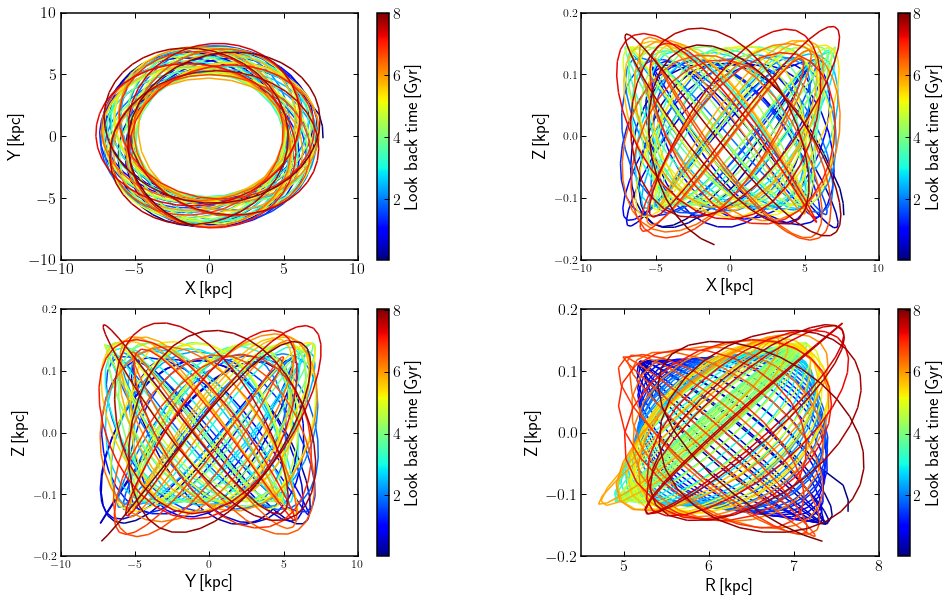

In [20]:
f, ax  = plt.subplots(2, 2, figsize=(16,10))
gs = gridspec.GridSpec(2, 2, wspace=0.4)

cmap = 'jet'


###first star
f0_ax1 = plt.subplot(gs[0])
# f0_ax1.plot(st0["X_GC(kpc)"] [0],st0["Y_GC(kpc)"][0],'o', mec='black', mfc='none', markersize=8)
points0 = np.array([st0_0,st0_1]).T.reshape(-1,1,2)
segments0 = np.concatenate([points0[:-1], points0[1:]], axis=1)
norm0 = plt.Normalize(time_0.min(), time_0.max())
lc0 =LineCollection(segments0, cmap=cmap, norm=norm0)
lc0.set_array(time_0)
lc0.set_linewidth(1.5)
line0 = f0_ax1.add_collection(lc0)

clb = f.colorbar(line0, ax=f0_ax1)
clb.ax.set_ylabel('Look back time\,[Gyr]',fontsize=18)


#####
f0_ax2 = plt.subplot(gs[1])
# f0_ax2.plot(st0["X_GC(kpc)"] [0],st0["Z_GC(kpc)"][0],'o', mec='black', mfc='none', markersize=8)
f0_ax2.tick_params(axis="both", which='major',direction="in", labelsize=12)
points1 = np.array([st0_0,st0_2]).T.reshape(-1,1,2)
segments1 = np.concatenate([points1[:-1], points1[1:]], axis=1)
norm1 = plt.Normalize(time_0.min(), time_0.max())
lc1 =LineCollection(segments1, cmap=cmap, norm=norm1)
lc1.set_array(time_0)
lc1.set_linewidth(1.5)
line1 = f0_ax2.add_collection(lc1)

clb = f.colorbar(line1, ax=f0_ax2)
clb.ax.set_ylabel('Look back time\,[Gyr]',fontsize=18)


#######
f0_ax3 = plt.subplot(gs[2])
# f0_ax3.plot(st0["Y_GC(kpc)"] [0],st0["Z_GC(kpc)"][0],'o', mec='black', mfc='none', markersize=8)
f0_ax3.tick_params(axis="both", which='major',direction="in", labelsize=12)
points2 = np.array([st0_1,st0_2]).T.reshape(-1,1,2)
segments2 = np.concatenate([points2[:-1], points2[1:]], axis=1)
norm2 = plt.Normalize(time_0.min(), time_0.max())
lc2 =LineCollection(segments2, cmap=cmap, norm=norm2)
lc2.set_array(time_0)
lc2.set_linewidth(1.5)
line2 = f0_ax3.add_collection(lc2)

clb = f.colorbar(line2, ax=f0_ax3)
clb.ax.set_ylabel('Look back time\,[Gyr]',fontsize=18)


#######
f0_ax4 = plt.subplot(gs[3])
# f0_ax4.plot(st0["Z_GC(kpc)"][0],st0["R_GC(kpc)"][0],'o', mec='black', mfc='none', markersize=8)
points3 = np.array([(st0_0**2+st0_1**2)**0.5,st0_2]).T.reshape(-1,1,2)
segments3 = np.concatenate([points3[:-1], points3[1:]], axis=1)
norm3 = plt.Normalize(time_0.min(), time_0.max())
lc3 =LineCollection(segments3, cmap=cmap, norm=norm3)
lc3.set_array(time_0)
lc3.set_linewidth(1.5)
line3 = f0_ax4.add_collection(lc3)
clb = f.colorbar(line3, ax=f0_ax4)

clb.ax.set_ylabel('Look back time\,[Gyr]', fontsize=18)
# Constraints
f0_ax1.set_ylabel("Y\,[kpc]", size=18)
f0_ax2.set_ylabel("Z\,[kpc]", size=18)
f0_ax3.set_ylabel("Z\,[kpc]", size=18)
f0_ax4.set_ylabel("Z\,[kpc]", size=18)
f0_ax1.set_xlabel("X\,[kpc]", size=18)
f0_ax2.set_xlabel("X\,[kpc]", size=18)
f0_ax3.set_xlabel("Y\,[kpc]", size=18)
f0_ax4.set_xlabel("R\,[kpc]", size=18)

f0_ax1.set_xlim([-10,10])
f0_ax1.set_ylim([-10,10])
f0_ax2.set_xlim([-10,10])
f0_ax2.set_ylim([-0.2,0.2])
f0_ax3.set_xlim([-10,10])
f0_ax3.set_ylim([-0.2,0.2])
f0_ax4.set_xlim([4.5,8])
f0_ax4.set_ylim([-0.2,0.2])


f0_ax1.xaxis.set_major_locator(ticker.MultipleLocator(5))
f0_ax2.xaxis.set_major_locator(ticker.MultipleLocator(5))
f0_ax3.xaxis.set_major_locator(ticker.MultipleLocator(5))
f0_ax4.xaxis.set_major_locator(ticker.MultipleLocator(1))


f0_ax2.set_yticks([-0.2,-0.1,0,0.2,0.1])
f0_ax3.set_yticks([-0.2,-0.1,0,0.2,0.1])
f0_ax4.set_yticks([-0.2,-0.1,0,0.2,0.1])


plt.savefig('orbits_orient.pdf',transparent = True, bbox_inches = 'tight')
